<a href="https://colab.research.google.com/github/Uemerson/masters-degree-in-computer-science-from-unesp/blob/main/voxelmorph/oasis/BPCA/100_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
!git clone https://github.com/voxelmorph/voxelmorph.git # getting vxm from git to use scripts
!pip install neurite

Cloning into 'voxelmorph'...
remote: Enumerating objects: 3228, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 3228 (delta 8), reused 15 (delta 6), pack-reused 3202
Receiving objects: 100% (3228/3228), 129.18 MiB | 22.78 MiB/s, done.
Resolving deltas: 100% (2072/2072), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.3-py3-none-any.whl size=19549 sha256=42d8329d100df4ea3eadec8ab20af4209cabc2c3b94f44c150b211e325601caf
  Stored in directory: /root/.cache/pip/wheels/33/42/e2/6312e2cd3efadacc2714759efc7c7dc1513db7853e8bd508f6
Successfully built pystrum


In [2]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import sys 
sys.path.append('voxelmorph')
import voxelmorph as vxm
import time

import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

np.random.seed(777)
tf.random.set_seed(777)

# disable eager execution
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True) # https://github.com/tensorflow/tensorflow/issues/54458


# Connect to driver

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Download dataset OASIS

In [5]:
# get neurite-OASIS data
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
!mkdir OASIS
!tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS'

# !wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar
# !mkdir OASIS
# !tar xf neurite-oasis.v1.0.tar --directory 'OASIS'

--2023-05-05 20:26:45--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24903680 (24M) [application/x-tar]
Saving to: ‘neurite-oasis.2d.v1.0.tar’

neurite-oasis.2d.v1 100%[===================>]  23.75M  18.6MB/s    in 1.3s    

2023-05-05 20:26:47 (18.6 MB/s) - ‘neurite-oasis.2d.v1.0.tar’ saved [24903680/24903680]



In [6]:
# write a list of OASIS subjects to a training file
import pathlib
path = pathlib.Path('/content/OASIS')
subj_lst_m = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]
with open('train_list.txt','w') as tfile:
	tfile.write('\n'.join(subj_lst_m))

# Train

Epoch 1/100
100/100 [==============================] - 20s 27ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0068 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_resize_loss: 8.8043e-05
Epoch 2/100
100/100 [==============================] - 3s 30ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_resize_loss: 4.4998e-04
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0059 - vxm_dense_transformer_loss: 0.0057 - vxm_dense_flow_resize_loss: 0.0165
Epoch 4/100
100/100 [==============================] - 3s 26ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0047 - vxm_dense_transformer_loss: 0.0042 - vxm_dense_flow_resize_loss: 0.0537
Epoch 5/100
100/100 [==============================] - 3s 25ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0043 - vxm_dense_transformer_loss: 0.0037 - vxm_dense_flow_resize_loss: 0.0652
Epoch 6/100
100/100 [=========================

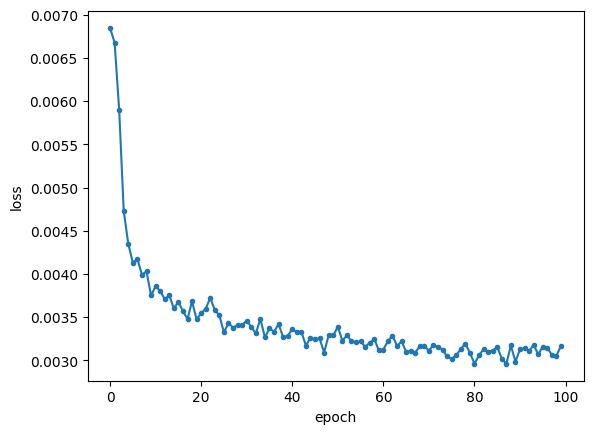

In [7]:
# training parameters
class Args:
  img_list: str = 'train_list.txt'
  img_prefix: str = None
  img_suffix: str = None
  atlas: str = None
  model_dir: str = 'models'
  multichannel: bool = False
  gpu: int = 0
  batch_size: int = 1
  epochs: int = 1500
  steps_per_epoch: int = 100
  load_weights: str = None
  initial_epoch: int = 0
  lr: float = 1e-4
  enc: list = None
  dec: list = None
  int_steps: int = 7
  int_downsize: int = 2
  use_probs: bool = False
  bidir: bool = False
  image_loss: str = 'mse'
  lambda_weight: float = 0.01
  kl_lambda: float = 10
  image_sigma: float = 1.0

args = Args()
args.epochs = 100

# load and prepare training data
train_files = vxm.py.utils.read_file_list(args.img_list, prefix=args.img_prefix,
                                          suffix=args.img_suffix)
assert len(train_files) > 0, 'Could not find any training data.'

# no need to append an extra feature axis if data is multichannel
add_feat_axis = not args.multichannel

if args.atlas:
    # scan-to-atlas generator
    atlas = vxm.py.utils.load_volfile(args.atlas, np_var='vol',
                                      add_batch_axis=True, add_feat_axis=add_feat_axis)
    generator = vxm.generators.scan_to_atlas(train_files, atlas,
                                             batch_size=args.batch_size,
                                             bidir=args.bidir,
                                             add_feat_axis=add_feat_axis)
else:
    # scan-to-scan generator
    generator = vxm.generators.scan_to_scan(
        train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis)

# extract shape and number of features from sampled input
sample_shape = next(generator)[0][0].shape
inshape = sample_shape[1:-1]
nfeats = sample_shape[-1]

# prepare model folder
model_dir = args.model_dir
os.makedirs(model_dir, exist_ok=True)

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(args.gpu)
assert np.mod(args.batch_size, nb_devices) == 0, \
    'Batch size (%d) should be a multiple of the nr of gpus (%d)' % (args.batch_size, nb_devices)

# unet architecture
enc_nf = args.enc if args.enc else [16, 32, 32, 32]
dec_nf = args.dec if args.dec else [32, 32, 32, 32, 32, 16, 16]

# prepare model checkpoint save path
save_filename = os.path.join(model_dir, '{epoch:04d}.h5')

# build the model
model = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=args.bidir,
    use_probs=args.use_probs,
    int_steps=args.int_steps,
    int_resolution=args.int_downsize,
    src_feats=nfeats,
    trg_feats=nfeats
)

# load initial weights (if provided)
if args.load_weights:
    model.load_weights(args.load_weights)

# prepare image loss
if args.image_loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.image_loss == 'mse':
    image_loss_func = vxm.losses.MSE(args.image_sigma).loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

# need two image loss functions if bidirectional
if args.bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]

# prepare deformation loss
if args.use_probs:
    flow_shape = model.outputs[-1].shape[1:-1]
    losses += [vxm.losses.KL(args.kl_lambda, flow_shape).loss]
else:
    losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]

weights += [args.lambda_weight]

# multi-gpu support
if nb_devices > 1:
    save_callback = vxm.networks.ModelCheckpointParallel(save_filename)
    model = tf.keras.utils.multi_gpu_model(model, gpus=nb_devices)
else:
    save_callback = tf.keras.callbacks.ModelCheckpoint(save_filename, 
                                                       save_freq=20 * args.steps_per_epoch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=args.lr), loss=losses, loss_weights=weights)

# save starting weights
# model.save(save_filename.format(epoch=args.initial_epoch))

hist = model.fit(generator,
         initial_epoch=args.initial_epoch,
         epochs=args.epochs,
         steps_per_epoch=args.steps_per_epoch,
         callbacks=[save_callback],
         verbose=1
        )

# saving the model in tensorflow format
model.save(f'./{args.epochs}_tf',save_format='tf')

# plot training history.
plt.figure()
plt.plot(hist.epoch, hist.history['loss'], '.-')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [8]:
!zip -r 100-epoch-models.zip /content/models/
!zip -r 100-tf.zip /content/100_tf/

  adding: content/models/ (stored 0%)
  adding: content/models/0100.h5 (deflated 15%)
  adding: content/models/0020.h5 (deflated 15%)
  adding: content/models/0060.h5 (deflated 15%)
  adding: content/models/0080.h5 (deflated 15%)
  adding: content/models/0040.h5 (deflated 15%)
  adding: content/100_tf/ (stored 0%)
  adding: content/100_tf/assets/ (stored 0%)
  adding: content/100_tf/saved_model.pb (deflated 94%)
  adding: content/100_tf/variables/ (stored 0%)
  adding: content/100_tf/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/100_tf/variables/variables.index (deflated 75%)
  adding: content/100_tf/keras_metadata.pb (deflated 92%)
  adding: content/100_tf/fingerprint.pb (stored 0%)


In [9]:
!cp 100-epoch-models.zip "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with BPCA/"
!cp 100-tf.zip "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with BPCA/"

# Registration

In [10]:
from matplotlib.image import NonUniformImage
class Args:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

args = Args()
args.moving = '/content/OASIS/OASIS_OAS1_0001_MR1/slice_orig.nii.gz'
args.fixed = '/content/OASIS/OASIS_OAS1_0001_MR1/slice_norm.nii.gz'
args.moved = 'moved.nii.gz'
args.warp = 'warp.nii.gz'
args.model = '/content/models/0100.h5'
args.gpu = 0

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(args.gpu)

# load moving and fixed images
add_feat_axis = not args.multichannel
moving = vxm.py.utils.load_volfile(args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)
fixed, fixed_affine = vxm.py.utils.load_volfile(
    args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    warp = vxm.networks.VxmDense.load(args.model, **config).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

# save warp
if args.warp:
    vxm.py.utils.save_volfile(warp.squeeze(), args.warp, fixed_affine)

# save moved image
vxm.py.utils.save_volfile(moved.squeeze(), args.moved, fixed_affine)


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


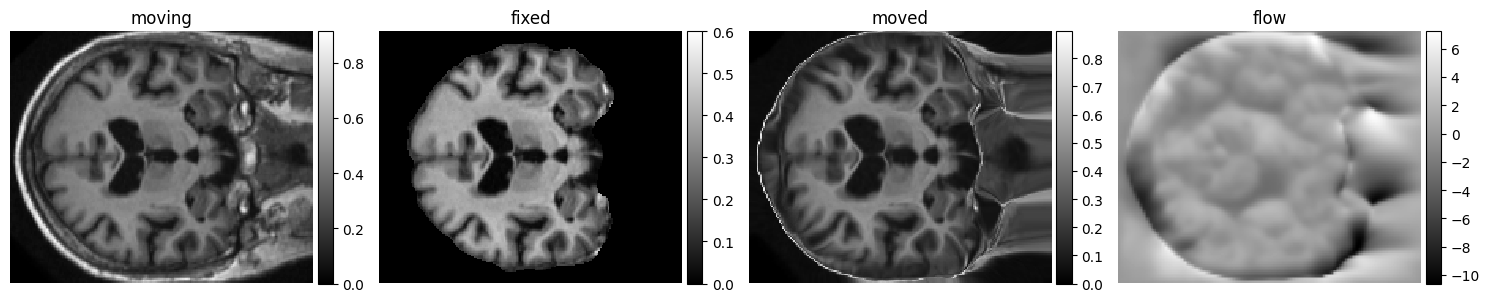

In [11]:
# visualize registration
images = [img[0, :, :, 0] for img in [moving, fixed, moved, warp]]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

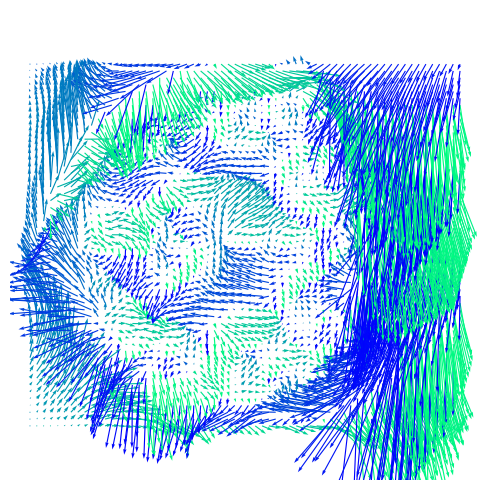

In [12]:
# visualize flow
flow = warp.squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

# Testing (measuring Dice scores)

In [13]:
# keep track of all dice scores
reg_times = []
dice_means = []

img_pairs = [
    [
      '/content/OASIS/OASIS_OAS1_0001_MR1/slice_orig.nii.gz',
      '/content/OASIS/OASIS_OAS1_0001_MR1/slice_norm.nii.gz'
    ]
]

seg_pairs = [
    [
        '/content/OASIS/OASIS_OAS1_0001_MR1/slice_seg24.nii.gz',
        '/content/OASIS/OASIS_OAS1_0001_MR1/slice_seg24.nii.gz'
    ],
]

class Args:
  model: str = None
  labels = None

args = Args()
args.model = '/content/models/0100.h5'

labels = np.load(args.labels) if args.labels else None

with tf.device(device):
    # load model and build nearest-neighbor transfer model
    model = vxm.networks.VxmDense.load(args.model, input_model=None)
    registration_model = model.get_registration_model()
    inshape = registration_model.inputs[0].shape[1:-1]
    transform_model = vxm.networks.Transform(inshape, interp_method='nearest')

    for i in range(len(img_pairs)):

        # load moving image and seg
        moving_vol = vxm.py.utils.load_volfile(
            img_pairs[i][0], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        moving_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][0], np_var='seg', add_batch_axis=True, add_feat_axis=add_feat_axis)

        # load fixed image and seg
        fixed_vol = vxm.py.utils.load_volfile(
            img_pairs[i][1], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        fixed_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][1], np_var='seg')

        # predict warp and time
        start = time.time()
        warp = registration_model.predict([moving_vol, fixed_vol])
        reg_time = time.time() - start
        if i != 0:
            # first keras prediction is generally rather slow
            reg_times.append(reg_time)

        # apply transform
        warped_seg = transform_model.predict([moving_seg, warp]).squeeze()

        # compute volume overlap (dice)
        overlap = vxm.py.utils.dice(warped_seg, fixed_seg, labels=labels)
        dice_means.append(np.mean(overlap))
        print('Pair %d    Reg Time: %.4f    Dice: %.4f +/- %.4f' % (i + 1, reg_time,
                                                                    np.mean(overlap),
                                                                    np.std(overlap)))

print()
print('Avg Reg Time: %.4f +/- %.4f  (skipping first prediction)' % (np.mean(reg_times),
                                                                    np.std(reg_times)))
print('Avg Dice: %.4f +/- %.4f' % (np.mean(dice_means), np.std(dice_means)))

Pair 1    Reg Time: 3.0249    Dice: 0.6990 +/- 0.2383

Avg Reg Time: nan +/- nan  (skipping first prediction)
Avg Dice: 0.6990 +/- 0.0000


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Run scripts

In [ ]:
# write a list of OASIS subjects to a training file
import pathlib
path = pathlib.Path('/content/OASIS')
subj_lst_m = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]
with open('train_list.txt','w') as tfile:
	tfile.write('\n'.join(subj_lst_m))

In [ ]:
%run -i /content/voxelmorph/scripts/tf/train.py \
--img-list 'train_list.txt' \
--epochs 100

In [ ]:
%run /content/voxelmorph/scripts/tf/register.py \
--moving /content/OASIS/OASIS_OAS1_0001_MR1/slice_orig.nii.gz \
--fixed /content/OASIS/OASIS_OAS1_0001_MR1/slice_norm.nii.gz \
--moved moved.nii.gz \
--warp warp.nii.gz \
--model /content/models/0100.h5 \
--gpu 0

In [ ]:
%run -i /content/voxelmorph/scripts/tf/test.py \
--model /content/models/0100.h5 \
--pairs /content/pairs.txt \
--img-prefix /content/OASIS/ \
--seg-prefix /content/OASIS/ \
--img-suffix /slice_norm.nii.gz \
--seg-suffix /slice_seg24.nii.gz

# Some annotations

Explain of testing script:

https://github.com/voxelmorph/voxelmorph/issues/373